In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
state_dim=10
lstm_hidden = 128
mlp_hidden = 128
num_layers = 1
dropout = 0.1
max_len = 7
# rate = 23
# minus = 0.13
gamma = 0.99
alpha = 0.005
beta = 0.003084
lr = 5e-5
weight_decay = 1e-4
bench_name = "shareGPT"
base_model_name = "llama3.1"
dataset_path = "../data/scores_rb/shareGPT-llama3-d7-topk10-t1"
td = "t1d7"
eagen_minus_time =  0.07067
eaforward_time = 0.002684
eye_time = 0.0004
name_str = f"eg-{eagen_minus_time:.5f}-ef-{eaforward_time:.5f}-eye-{eye_time:.5f}-b-{beta:.5f}-a-{alpha:.5f}-g-{gamma:.2f}-lr-{lr:.0e}-wd-{weight_decay:.0e}"

In [3]:
name_str

'eg-0.07067-ef-0.00268-eye-0.00040-b-0.00308-a-0.00500-g-0.99-lr-5e-05-wd-1e-04'

## 策略模型定义

In [4]:
import torch
import torch.nn as nn

class LSTMPolicyNet(nn.Module):
    def __init__(self, state_dim=10, lstm_hidden=128, mlp_hidden=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.state_dim = state_dim
        self.lstm_hidden = lstm_hidden
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=state_dim,
            hidden_size=lstm_hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.mlp = nn.Sequential(
            nn.Linear(lstm_hidden + state_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, 2)  # 输出2个动作的logits
        )

    def forward(self, state_seq, hidden=None):
        """
        state_seq: [B, T, state_dim]  # batch, seq_len, state_dim
        hidden: (h0, c0) tuple for LSTM initial state (optional)
        Returns:
            action_logits: [B, T, 2]  # 每个时刻的动作分数
        """
        lstm_out, hidden = self.lstm(state_seq, hidden)  # lstm_out: [B, T, lstm_hidden]
        logits = self.mlp(torch.cat((lstm_out, state_seq), dim=-1))  # [B, T, lstm_hidden + state_dim] -> [B, T, 2]
        return logits, hidden

    def act(self, state_seq, hidden=None, deterministic=False):
        """
        用于采样动作
        state_seq: [B, T, state_dim]
        Returns:
            actions: [B, T]
        """
        logits, hidden = self.forward(state_seq, hidden)
        probs = torch.softmax(logits, dim=-1)
        if deterministic:
            actions = torch.argmax(probs, dim=-1)
        else:
            dist = torch.distributions.Categorical(probs)
            actions = dist.sample()
        return actions, probs, hidden

    def reset_hidden(self, batch_size):
        """
        重置LSTM的隐藏状态
        batch_size: int
        Returns:
            hidden: (h0, c0) tuple for LSTM initial state
        """
        h0 = torch.zeros(self.num_layers, batch_size, self.lstm_hidden).to(next(self.parameters()).device)
        c0 = torch.zeros(self.num_layers, batch_size, self.lstm_hidden).to(next(self.parameters()).device)
        return (h0, c0)

## 加载ReplayDataset

In [5]:
import datasets

ReplayDataset = datasets.load_from_disk(dataset_path)

## 数据集预处理

In [6]:
import numpy as np

def avg_acc_len_fn(stop_probs):
    return np.sum(np.arange(len(stop_probs)) * np.array(stop_probs, dtype=np.float32))

def avg_acc_len_fn_tensor(stop_probs:torch.Tensor):
    """stop_probs: [B, T]"""
    return torch.sum(torch.arange(stop_probs.size(-1), device=stop_probs.device) * stop_probs, dim=-1)

def padding_stops(stops, max_len=9):
    """
    对stops进行padding，使其长度为max_len
    0~8共9个位置
    """
    padded_stops = stops + [0.0] * (max_len - len(stops))
    return padded_stops[:max_len]  # 确保长度不超过max_len

## 数据集定义

In [7]:
from torch.utils.data import Dataset
import numpy as np

def normalize_probs(arr:np.array):
    arr = np.clip(arr, 0, None)
    row_sums = arr.sum(axis=-1, keepdims=True)
    # 如果存在全为0的行就报错
    if np.any(row_sums <= 1e-8):
        raise ValueError("dataset error")
    arr = arr / row_sums
    return arr.tolist()

class SharedStatesDataset(Dataset):
    def __init__(self, dataset, max_len=7):
        self.samples = []
        for sample in dataset:
            # 仅用eagle_1_forward ~ eagle_7_forward
            state_seq = [sample[f'eagle_{i}_forward'] for i in range(1, max_len+1)]  # [7, state_dim]
            stops = [padding_stops(sample[f'action_{i}']['stop']) for i in range(max_len+1)]
            stops = [normalize_probs(np.array(stop)) for stop in stops]
            avg_acc_lens_op = avg_acc_len_fn(stops[-1])  # 最优平均接受长度
            self.samples.append({
                "states": state_seq,     # [7, state_dim]
                "stop_probs": stops,
                "avg_acc_lens_op": avg_acc_lens_op
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def collate_fn(batch):
    states = torch.tensor([x["states"] for x in batch], dtype=torch.float32) # [B, 7, state_dim]
    stop_probs = torch.tensor([x["stop_probs"] for x in batch], dtype=torch.float32)  # [B, 8, 9]
    avg_acc_lens_op = torch.tensor([x["avg_acc_lens_op"] for x in batch], dtype=torch.float32)  # [B]
    return states, stop_probs, avg_acc_lens_op  


In [8]:
num_paths = max_len + 1  # 8

In [9]:
from torch.utils.data import DataLoader
train_set = ReplayDataset["train"]
test_set = ReplayDataset["test"]
train_dataset = SharedStatesDataset(train_set, max_len=max_len)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataset = SharedStatesDataset(test_set, max_len=max_len)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

## 构造速度矩阵

In [10]:
def eagen_time(eagen_minus_time=0.07067, eaforward_time=0.002684, max_len=7):
    return eagen_minus_time + eaforward_time * max_len

def make_speed_matrix_hawkeye(eagen_minus_time=0.07067, eaforward_time=0.002684, eye_time=0.0004, max_len=7):
    acc_len = torch.arange(0, max_len + 2) # [0, 1, 2, ..., max_len+1]
    action_idx = torch.arange(max_len + 1)
    action_idx_ = torch.arange(max_len + 1)
    action_idx_[:-1] += 1
    t = eagen_minus_time + eaforward_time * action_idx + eye_time * action_idx_ # shape: [max_len + 1]
    speed_matrix = acc_len.unsqueeze(1) / t.unsqueeze(0)
    return speed_matrix  # [9, 8] acclen,action_idx

In [11]:
eatime = eagen_time(eagen_minus_time, eaforward_time, max_len)
speed_matrix = make_speed_matrix_hawkeye(eagen_minus_time, eaforward_time, eye_time, max_len)

In [12]:
eatime, speed_matrix

(0.089458,
 tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000],
         [ 14.0706,  13.4854,  12.9470,  12.4499,  11.9895,  11.5620,  11.1640,
           10.8392],
         [ 28.1413,  26.9709,  25.8940,  24.8998,  23.9791,  23.1241,  22.3279,
           21.6783],
         [ 42.2119,  40.4563,  38.8410,  37.3497,  35.9686,  34.6861,  33.4919,
           32.5175],
         [ 56.2825,  53.9418,  51.7880,  49.7996,  47.9582,  46.2481,  44.6558,
           43.3567],
         [ 70.3532,  67.4272,  64.7350,  62.2494,  59.9477,  57.8101,  55.8198,
           54.1958],
         [ 84.4238,  80.9127,  77.6820,  74.6993,  71.9373,  69.3722,  66.9837,
           65.0350],
         [ 98.4944,  94.3981,  90.6290,  87.1492,  83.9268,  80.9342,  78.1477,
           75.8742],
         [112.5651, 107.8836, 103.5760,  99.5991,  95.9164,  92.4962,  89.3116,
           86.7133]]))

## 构造奖励矩阵

In [13]:
# def process_eye_time(action_idx, rate, maxlen, minus):
#     if action_idx < maxlen:
#         return (rate + 1) + action_idx
#     else:
#         return (rate + 1) + action_idx - minus

def make_reward_matrix(maxlen=7, beta=0.003084, alpha=0.004, speed_matrix=None):
    action_ext = torch.tensor(
        [
            [1] * i + [0] * (maxlen - i + 1) for i in range(maxlen + 1)
        ]
    )
    reward_ext = -alpha * action_ext.unsqueeze(0).repeat_interleave(maxlen + 2, dim=0)  # [9, 8, 8]
    for acclen in range(maxlen + 2):
        for action_idx in range(maxlen + 1):
            reward_ext[acclen, action_idx, action_idx] = beta * speed_matrix[acclen, action_idx] #beta * acclen / process_eye_time(action_idx, rate, maxlen, minus)
    return reward_ext  # [9, 8, 8]

def make_g_matrix(reward_matrix, maxlen=7, gamma=0.99):
    G = reward_matrix.clone()
    for i in reversed(range(1, maxlen + 1)):
        G[:, :, i - 1].add_(gamma * G[:, :, i])
    return G[:,:,:-1]  # [9, 8, 7] acclen,action_idx,gamma_reward

## 统计接受长度分布、平均接受长度

In [14]:
def find_first_zero_pos(tensor):
    """
    参数:
        tensor: 输入张量，形状为[bsz, 8]，仅包含整数值0或1
    
    返回:
        形状为[bsz, 1]的张量，表示每行第一个0的位置（若没有则为8）
    """
    # 步骤1: 创建布尔掩码标记0的位置
    mask = tensor.eq(0)  # 等同于 (tensor == 0)
    mask = mask.to(torch.long)
    
    # 步骤2: 在最后一维末尾添加全True的列
    extended_mask = torch.cat(
        [mask, torch.ones(mask.size(0), 1, dtype=torch.long, device=tensor.device)],
        dim=1
    )
    
    # 步骤3: 沿最后一维查找第一个True的位置索引
    first_zero_pos = extended_mask.argmax(dim=1, keepdim=True)
    return first_zero_pos

from collections import defaultdict
def cal_avg_len(model, data_loader, eatime, speed_matrix):
    model.eval()
    device = next(model.parameters()).device
    len_dict = defaultdict(list)

    with torch.no_grad():
        for states, stop_probs, avg_acc_lens_op in data_loader:
            states = states.to(device)
            stop_probs = stop_probs.to(device)  # [B, 8, 9]
            avg_acc_lens_op = avg_acc_lens_op.to(device)  # [B]
            speed_matrix = speed_matrix.to(device)  # [9, 8]
            # states: [B, 7, state_dim], stop_probs: [B, 8, 8], avg_acc_lens_op: [B]
            batch_size = states.size(0)
            hidden = model.reset_hidden(batch_size)
            actions, _, _ = model.act(states, hidden)  # [B, T]
            # actions中第一个0出现的位置为动作序列长度
            action_length = find_first_zero_pos(actions)  # [B, 1]
            len_dict["action_length"].extend(action_length.squeeze(1).cpu().numpy())
            expanded_index = action_length.unsqueeze(-1).expand(-1, -1, stop_probs.size(-1))  # [B, 1, max_len + 1]
            action_stop_probs = stop_probs.gather(dim=1, index=expanded_index).squeeze(1) # [B, max_len + 1]

            #计算eagle速度
            speed_ea = avg_acc_lens_op / eatime
            len_dict["eagle_speed"].extend(speed_ea.cpu().numpy())
            #计算eye速度
            acc_lens_sampled = torch.multinomial(action_stop_probs, num_samples=1) # [B, 1]
            speed_hawkeye = speed_matrix[acc_lens_sampled.squeeze(1), action_length.squeeze(1)]  # [B, 1]
            len_dict["eye_speed"].extend(speed_hawkeye.cpu().numpy())

            # 计算平均接受长度
            avg_acc_lens = avg_acc_len_fn_tensor(action_stop_probs) # [B]
            len_dict["avg_acc_lens"].extend(avg_acc_lens.cpu().numpy())
            # 计算与最优平均接受长度差值
            optimal_avg_acc_lens = avg_acc_lens - avg_acc_lens_op
            len_dict["optimal_avg_acc_lens_diff"].extend(optimal_avg_acc_lens.cpu().numpy())
            
    return len_dict
    

## 测试代码

In [15]:
def evaluate_loss(model, data_loader, device):
    model.eval()
    total_loss = 0
    total_batches = 0
    G = make_g_matrix(make_reward_matrix(maxlen=max_len, beta=beta, alpha=alpha, speed_matrix=speed_matrix), maxlen=max_len, gamma=gamma)  # [9, 8, 7]
    G = G.to(device)

    with torch.no_grad():
        for states, stop_probs, _ in data_loader:
            states = states.to(device)
            stop_probs = stop_probs.to(device)  # [B, 8, 9]
            logits, _ = model(states)  # [B, 7, 2]

            log_probs = nn.functional.log_softmax(logits, dim=-1)  # [B, 7, 2]
            probs = torch.softmax(logits, dim=-1)  # [B, 7, 2]
            action_dist = torch.distributions.Categorical(probs=probs)  # 创建Categorical分布
            sampled_actions = action_dist.sample()  # 采样动作 [B, 7]
            action_indices = find_first_zero_pos(sampled_actions)  # [B, 1]
            accept_length_dist = torch.distributions.Categorical(
                probs=stop_probs.gather(dim=1, index=action_indices.unsqueeze(-1).expand(-1, -1, stop_probs.size(-1)))
            )
            accept_lengths = accept_length_dist.sample()  # [B, 1]
            # 计算回报 g = G[action_idx, accept_length, :]
            g_matrix = G[accept_lengths.squeeze(-1).to(device), action_indices.squeeze(-1).to(device), :]  # [B, 7]
            # 计算损失
            action_log_probs = log_probs.gather(dim=-1, index=sampled_actions.unsqueeze(-1)).squeeze(-1)  # [B, 7]
            loss = -(action_log_probs * g_matrix).mean() # 平均损失
            total_loss += loss.item()
            total_batches += 1
    model.train()
    return total_loss / total_batches if total_batches > 0 else float('inf')

## 训练代码

Epoch 1, Train Loss: 0.0162, Test Loss: 0.0140
Best test loss updated: 0.0140, model checkpoint saved.
Epoch 2, Train Loss: 0.0128, Test Loss: 0.0120
Best test loss updated: 0.0120, model checkpoint saved.
Epoch 3, Train Loss: 0.0120, Test Loss: 0.0121
Epoch 4, Train Loss: 0.0106, Test Loss: 0.0109
Best test loss updated: 0.0109, model checkpoint saved.
Epoch 5, Train Loss: 0.0104, Test Loss: 0.0098
Best test loss updated: 0.0098, model checkpoint saved.
Epoch 6, Train Loss: 0.0105, Test Loss: 0.0102
Epoch 7, Train Loss: 0.0103, Test Loss: 0.0100
Epoch 8, Train Loss: 0.0102, Test Loss: 0.0104
Epoch 9, Train Loss: 0.0101, Test Loss: 0.0103
Epoch 10, Train Loss: 0.0100, Test Loss: 0.0104
Epoch 11, Train Loss: 0.0104, Test Loss: 0.0102
Epoch 12, Train Loss: 0.0102, Test Loss: 0.0104
Epoch 13, Train Loss: 0.0102, Test Loss: 0.0104
Epoch 14, Train Loss: 0.0100, Test Loss: 0.0099
Epoch 15, Train Loss: 0.0096, Test Loss: 0.0094
Best test loss updated: 0.0094, model checkpoint saved.
Epoch 16,

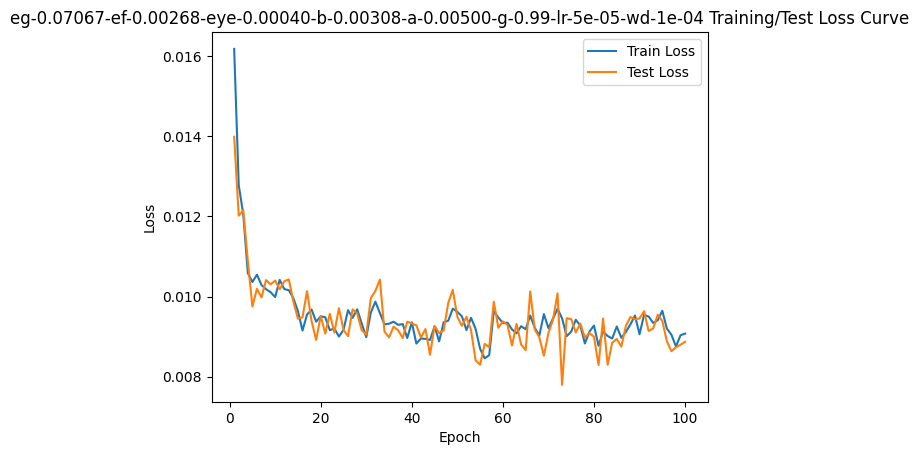

<All keys matched successfully>

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


state_dim = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMPolicyNet(state_dim=state_dim, lstm_hidden=lstm_hidden, mlp_hidden=mlp_hidden, num_layers=num_layers, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  

num_epochs = 100
train_losses = []
test_losses = []
best_test_loss = float('inf')
G = make_g_matrix(make_reward_matrix(maxlen=max_len, beta=beta, alpha=alpha, speed_matrix=speed_matrix), maxlen=max_len, gamma=gamma)  # [9, 8, 7]
G = G.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_batches = 0
    for states, stop_probs, _ in train_loader:
        states = states.to(device)
        stop_probs = stop_probs.to(device)  # [B, 8, 9]

        logits, _ = model(states)  # [B, 7, 2]
        log_probs = nn.functional.log_softmax(logits, dim=-1)  # [B, 7, 2]
        probs = torch.softmax(logits, dim=-1)  # [B, 7, 2]
        action_dist = torch.distributions.Categorical(probs=probs)  # 创建Categorical分布
        sampled_actions = action_dist.sample()  # 采样动作 [B, 7]
        action_indices = find_first_zero_pos(sampled_actions)  # [B, 1]
        accept_length_dist = torch.distributions.Categorical(
            probs=stop_probs.gather(dim=1, index=action_indices.unsqueeze(-1).expand(-1, -1, stop_probs.size(-1)))
        )
        accept_lengths = accept_length_dist.sample()  # [B, 1]
        # 计算回报 g = G[action_idx, accept_length, :]
        g_matrix = G[accept_lengths.squeeze(-1).to(device), action_indices.squeeze(-1).to(device), :]  # [B, 7]
        # 计算损失
        action_log_probs = log_probs.gather(dim=-1, index=sampled_actions.unsqueeze(-1)).squeeze(-1)  # [B, 7]
        loss = -(action_log_probs * g_matrix).mean()  # 平均损失
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1

    avg_train_loss = total_loss / total_batches if total_batches > 0 else 0
    avg_test_loss = evaluate_loss(model, test_loader, device)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), f"../output/{bench_name}/{base_model_name}/{td}/pt/{name_str}.pt")
            print(f"Best test loss updated: {best_test_loss:.4f}, model checkpoint saved.")

# 可视化loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"{name_str} Training/Test Loss Curve")
plt.savefig(f"../output/{bench_name}/{base_model_name}/{td}/pic/{name_str}-loss_curve.png")
plt.show()

# torch.save(model.state_dict(), "lstm_policy.pt")
model.load_state_dict(torch.load(f"../output/{bench_name}/{base_model_name}/{td}/pt/{name_str}.pt"))

In [32]:
len_dict = cal_avg_len(model, test_loader, eatime, speed_matrix)

In [18]:
len_dict

defaultdict(list,
            {'action_length': [3,
              0,
              1,
              7,
              4,
              0,
              3,
              2,
              5,
              7,
              0,
              2,
              0,
              2,
              4,
              3,
              5,
              7,
              3,
              2,
              2,
              7,
              7,
              5,
              6,
              3,
              1,
              0,
              4,
              4,
              1,
              1,
              3,
              2,
              6,
              3,
              7,
              1,
              0,
              6,
              1,
              7,
              7,
              1,
              7,
              2,
              7,
              6,
              0,
              4,
              0,
              7,
              7,
              3,
              3,
              7,
             

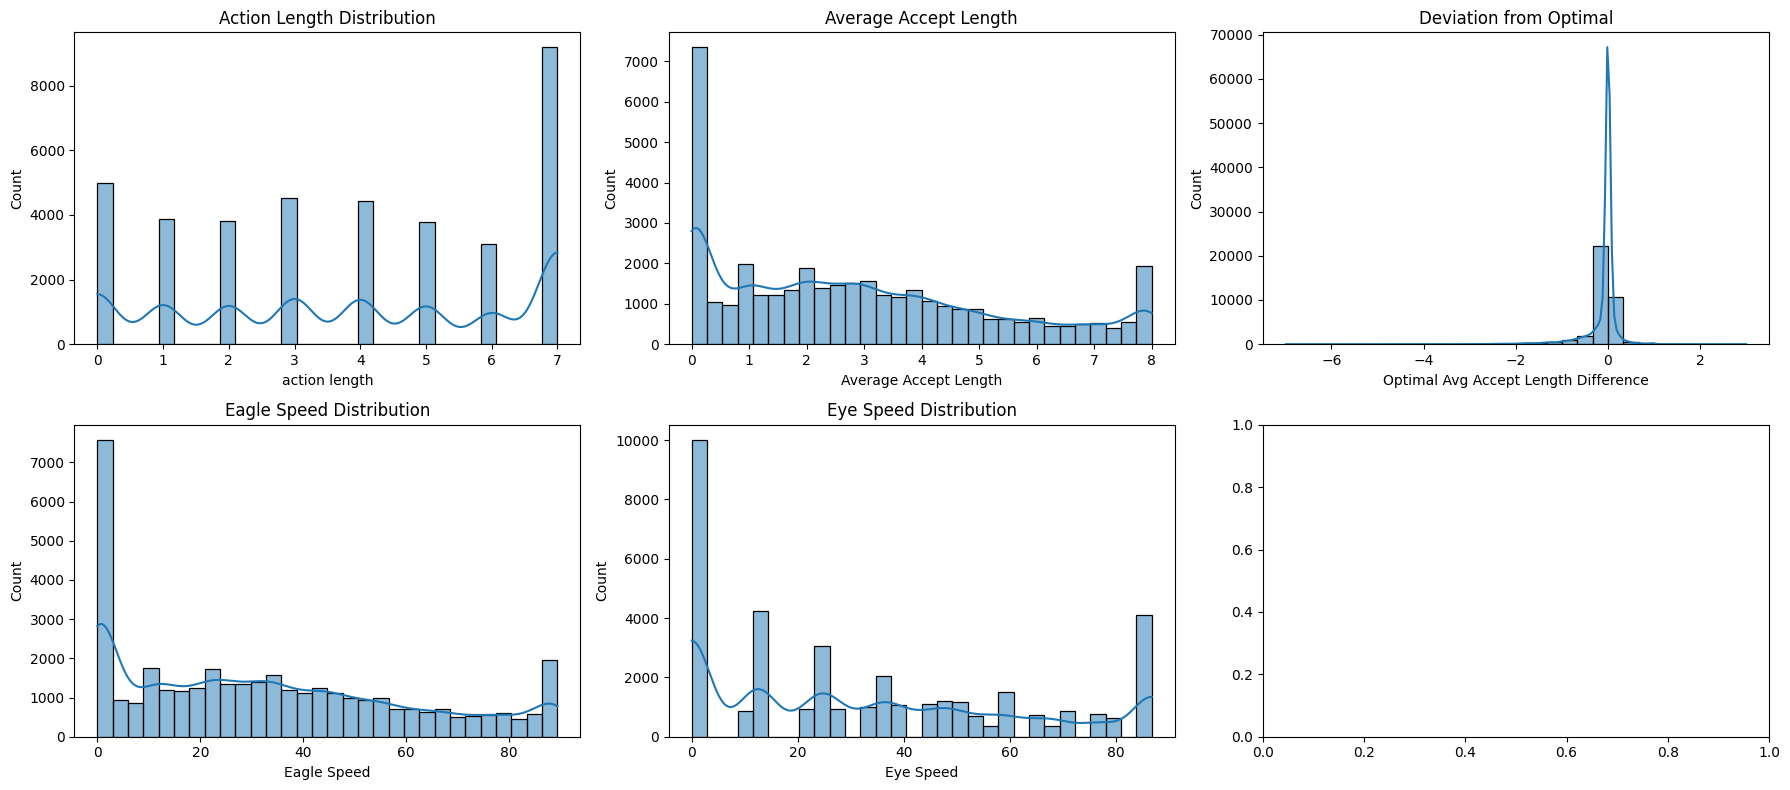

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(len_dict):
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    # 动作长度分布
    sns.histplot(len_dict["action_length"], kde=True, ax=axes[0, 0], bins=30)
    axes[0, 0].set_title(f"Action Length Distribution")
    axes[0, 0].set_xlabel("action length")
    
    # 平均接受长度分布
    sns.histplot(len_dict["avg_acc_lens"], kde=True, ax=axes[0, 1], bins=30)
    axes[0, 1].set_title(f"Average Accept Length")
    axes[0, 1].set_xlabel("Average Accept Length")

    # 与最优值差值分布
    sns.histplot(len_dict["optimal_avg_acc_lens_diff"], kde=True, ax=axes[0, 2], bins=30)
    axes[0, 2].set_title(f"Deviation from Optimal")
    axes[0, 2].set_xlabel("Optimal Avg Accept Length Difference")

    # eagle时间分布
    sns.histplot(len_dict["eagle_speed"], kde=True, ax=axes[1, 0], bins=30)
    axes[1, 0].set_title(f"Eagle Speed Distribution")
    axes[1, 0].set_xlabel("Eagle Speed")

    # eye时间分布
    sns.histplot(len_dict["eye_speed"], kde=True, ax=axes[1, 1], bins=30)
    axes[1, 1].set_title(f"Eye Speed Distribution")
    axes[1, 1].set_xlabel("Eye Speed")

    plt.tight_layout()
    plt.show()
    plt.savefig(f"../output/{bench_name}/{base_model_name}/{td}/pic/{name_str}-distributions.png")

plot_distributions(len_dict)

In [20]:
def print_stats(len_dict):
    print("===== 统计指标 =====")
    for key, values in len_dict.items():
        print(f"\n-- {key} --")
        print(f"样本数: {len(values)}")
        print(f"均值: {np.mean(values):.4f}")
        print(f"标准差: {np.std(values):.4f}")
        print(f"最小值: {np.min(values)}")
        print(f"25%分位数: {np.percentile(values, 25):.4f}")
        print(f"中位数: {np.median(values):.4f}")
        print(f"75%分位数: {np.percentile(values, 75):.4f}")
        print(f"最大值: {np.max(values)}")
print_stats(len_dict)

===== 统计指标 =====

-- action_length --
样本数: 37682
均值: 3.8337
标准差: 2.4840
最小值: 0
25%分位数: 2.0000
中位数: 4.0000
75%分位数: 6.0000
最大值: 7

-- eagle_speed --
样本数: 37682
均值: 33.0923
标准差: 27.3757
最小值: 0.0
25%分位数: 9.1435
中位数: 29.1279
75%分位数: 52.2630
最大值: 89.42743682861328

-- eye_speed --
样本数: 37682
均值: 32.8926
标准差: 29.4062
最小值: 0.0
25%分位数: 0.0000
中位数: 25.8940
75%分位数: 54.1958
最大值: 86.71334075927734

-- avg_acc_lens --
样本数: 37682
均值: 2.8684
标准差: 2.3984
最小值: 0.0
25%分位数: 0.8197
中位数: 2.4873
75%分位数: 4.4173
最大值: 8.0

-- optimal_avg_acc_lens_diff --
样本数: 37682
均值: -0.0920
标准差: 0.3902
最小值: -6.989260196685791
25%分位数: -0.0282
中位数: 0.0000
75%分位数: 0.0074
最大值: 2.9977593421936035


In [33]:
np.mean(len_dict["eye_speed"])

32.901215

In [34]:
np.mean(len_dict["eagle_speed"])

33.092342

In [35]:
np.mean(len_dict["eye_speed"]) / np.mean(len_dict["eagle_speed"])

0.9942244

In [23]:
import csv
from datetime import datetime

# 创建参数字典
params = {
    "state_dim": state_dim,
    "lstm_hidden": lstm_hidden,
    "mlp_hidden": mlp_hidden,
    "num_layers": num_layers,
    "dropout": dropout,
    "max_len": max_len,
    "gamma": gamma,
    "alpha": alpha,
    "beta": beta,
    "lr": lr,
    "weight_decay": weight_decay,
    "eagen_minus_time": eagen_minus_time,
    "eaforward_time": eaforward_time,
    "eye_time": eye_time,
    "bench_name": bench_name,
    "base_model_name": base_model_name,
    "dataset_path": dataset_path,
    "td": td,
}



# CSV文件名
filename = f"../output/{bench_name}/{base_model_name}/{td}/results.csv"

def save_to_csv(params, len_dict, filename):
    # 创建数据行字典
    data_row = params.copy()
    
    # 添加时间戳
    data_row["timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # 添加统计指标
    for key, values in len_dict.items():
        if len(values) > 0:
            # data_row[f"{key}_count"] = len(values)
            data_row[f"{key}_mean"] = np.mean(values)
            data_row[f"{key}_std"] = np.std(values)
            # data_row[f"{key}_min"] = np.min(values)
            data_row[f"{key}_25%"] = np.percentile(values, 25)
            # data_row[f"{key}_median"] = np.median(values)
            data_row[f"{key}_75%"] = np.percentile(values, 75)
            # data_row[f"{key}_max"] = np.max(values)
    
    data_row["ratio"] = np.mean(len_dict["eye_speed"]) / np.mean(len_dict["eagle_speed"])

    # 检查文件是否存在并创建表头
    file_exists = os.path.isfile(filename)
    
    # 写入CSV文件
    with open(filename, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=data_row.keys())
        
        # 如果是新文件，写入表头
        if not file_exists or f.tell() == 0:
            writer.writeheader()
        
        # 写入数据行
        writer.writerow(data_row)

# 调用函数保存结果
save_to_csv(params, len_dict, filename)